# Gaussian Imputation

Imputation is completing missing data points. In this experiment we are using conditional gauss posterior to predict missing values. Assume that our dataset has N sample with d features. Each sample is sampled from d-dimensional gaussian. For each sample we form conditional probability of missing value prior to visible values. 

The conditional probability of a missing value prior to visible values is given by:

$$
p(y_{\text{missed}} \mid y_{\text{visible}}) = \mathcal{N}(y_{\text{missed}} \mid \boldsymbol{\mu}_{\text{missed} \mid \text{visible}}, \boldsymbol{\Sigma}_{\text{missed} \mid \text{visible}})
$$

Where:
1. **Conditional Mean:**
   $$
   \boldsymbol{\mu}_{\text{missed} \mid \text{visible}} = \boldsymbol{\mu}_{\text{missed}} + \boldsymbol{\Sigma}_{\text{missed}, \text{visible}} \boldsymbol{\Sigma}_{\text{visible}, \text{visible}}^{-1} (y_{\text{visible}} - \boldsymbol{\mu}_{\text{visible}})
   $$

2. **Conditional Covariance:**
   $$
   \boldsymbol{\Sigma}_{\text{missed} \mid \text{visible}} = \boldsymbol{\Sigma}_{\text{missed}, \text{missed}} - \boldsymbol{\Sigma}_{\text{missed}, \text{visible}} \boldsymbol{\Sigma}_{\text{visible}, \text{visible}}^{-1} \boldsymbol{\Sigma}_{\text{visible}, \text{missed}}
   $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, laplace, norm
import seaborn as sns
from sklearn.datasets import make_spd_matrix
from gauss import gauss_sample,gauss_condition


In [17]:
# Generate data and make some part of it nan

d = 10 # dimension

# Generate data with random means and covariance matrix
mean = np.random.normal(size=(d,))
cov = make_spd_matrix(d)
x_true = gauss_sample(mean, cov, d)

# Make some part of the data nan
x_missed = x_true.copy()
nan_ratio = 0.5
nan_mask = np.random.rand(*x_missed.shape) < nan_ratio
x_missed[nan_mask] = np.nan


In [18]:
hidden_nodes = np.argwhere(np.isnan(x_missed[0, :]))
hidden_nodes

array([[0],
       [1],
       [6],
       [7],
       [8]])

In [19]:
def gauss_impute(mu,sigma,x_observed):
    n_data, _ = x_observed.shape
    x_imputed = np.copy(x_observed)
    for i in range(n_data):
        hidden_nodes = np.argwhere(np.isnan(x_observed[i, :]))
        visible_nodes = np.argwhere(~np.isnan(x_observed[i, :]))
        visible_values = np.zeros(len(visible_nodes))
        for tc, h in enumerate(visible_nodes):
            visible_values[tc] = x_observed[i, h]
        v = visible_nodes.reshape(len(visible_nodes))
        j = np.array(range(d))
        h = np.setdiff1d(j, v)
        mu_impute,sigma_impute = gauss_condition(mu,sigma,hidden_nodes,visible_nodes,visible_values)

        # Fill missed values with mu
        for rr,h in enumerate(hidden_nodes):
            x_imputed[i,h] = mu_impute[rr]
    
    return x_imputed
    
x_imputed = gauss_impute(mean, cov, x_missed)




/tmp/ipykernel_65780/2935907666.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  visible_values[tc] = x_observed[i, h]


In [20]:
# Captured from https://matplotlib.org/stable/gallery/specialty_plots/hinton_demo.html

import matplotlib.pyplot as plt
import numpy as np


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

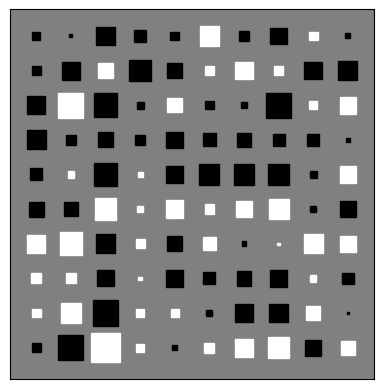

In [21]:
hinton(x_imputed)

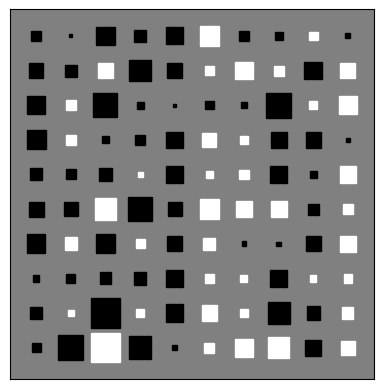

In [22]:
hinton(x_true)